# Simple Custon Radial Basis Neural Network

In [ ]:
# Importing needed libraries
from keras.utils import np_utils
from keras.datasets import mnist

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input

from keras.layers import Layer
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

import time

from sklearn.metrics import confusion_matrix

import warnings #needed for this type of classifier
warnings.simplefilter(action='ignore', category=Warning)

### Data Preprocessing Level

In [ ]:
# Load MNIST digit dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)




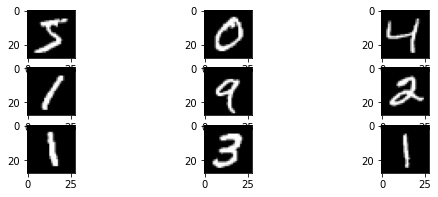

In [ ]:
# Plot a sample of the  data

# Dimensions of data
print('X_train: ' + str(x_train.shape))
print('Y_train: ' + str(y_train.shape))
print('X_test:  '  + str(x_test.shape))
print('Y_test:  '  + str(y_test.shape))
print('\n')

plt.figure(figsize=(9, 3))
for i in range(9):  
  plt.subplot(330 + 1 + i)
  plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
  
plt.show()

#### Handling the data to fit the model

**“Normalizing”** a vector most often means dividing by a norm of the vector. It also often refers to rescaling by the minimum and range of the vector, to make all the elements lie between 0 and 1 thus bringing all the values of numeric columns in the dataset to a common scale.

The goal of **normalization** is to change the values of numeric columns in the dataset to a common scale, without distorting differences in the ranges of values.

**One hot encoding** is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [ ]:
# Reshaping input size
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

# Normalization
x_train = x_train / 255.0
x_test = x_test / 255.0

# Labeling (one hot encoding)
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

**Principal component analysis (PCA)**:

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [ ]:
n_components = 100 #Best scenario according to diagrams and tests.

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(x_train)

x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

## Creating the model

#### RBF Layer

[RBF Layer Base Code](https://github.com/PetraVidnerova/rbf_for_tf2)

Creating custom initializers:

You can pass a custom callable as initializer. It must take the arguments ```shape``` (shape of the variable to initialize) and ```dtype``` (dtype of generated values).

If you need to configure your initializer via various arguments, you should implement it as a subclass of ```tf.keras.initializers.Initializer```.

Initializers should implement a ```__call__``` method 

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.initializers import RandomUniform, Initializer, Constant

from sklearn.cluster import KMeans

class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None):
        assert shape[1:] == self.X.shape[1:]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

Custom trainable keras layers:

To build your own keras layer you need to implement a class that is a subclass of keras.layers.Layer which implements three functions (plus ```__init__```): 
build, call, and compute_output_shape.

* ```build(self, input_shape)```

This is where you will define your weights. This method should end with calling ```super().build()```.

To define weights use the ```self.add_weight``` method. ```name```, ```initializer```, and ```trainable``` control the name, initialization settings (e.g. InitCentersRandom), and trainability (probably True) of the weight. 

**build** is the main method and its only purpose is to build the layer properly. It can do anything related to the inner working of the layer. Once the custom functionality is done, we can call the base class build function.

* ```call(self,x)```

**call** method does the exact working of the layer during training process.

* ```compute_output_shape(input_shape)```

This method should specify the output shape for a given input shape. It is used during compile time to validate that the shapes of the tensors passed between layers is correct.


In [ ]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim

        # betas is either initializer object or float
        if isinstance(betas, Initializer):
            self.betas_initializer = betas
        else:
            self.betas_initializer = Constant(value=betas)

        self.initializer = initializer if initializer else RandomUniform(
            0.0, 1.0)

        super().__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),  # defines the build method with one argument, input_shape. Shape of the input data is referred by input_shape.
                                       initializer=self.initializer,             # creates the weight corresponding to input shape and set it in the kernel. 
                                                                                 #It is our custom functionality of the layer. It creates the weight using given initializer.
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=self.betas_initializer,
                                     trainable=True)

        super().build(input_shape)                                               # calls the base class, build method.

    def call(self, x): 
        C = tf.expand_dims(self.centers, -1)                                     # inserts a dimension of 1
        H = tf.transpose(C-tf.transpose(x))                                      # matrix of differences
        return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))            # The gaussian function implementation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#### Neural Network Model Function

In [ ]:
# Function to create the model in order to use GridSearchCV for hyperparameter tuning.
def create_model(optimizer='adam', loss='mean_squared_error', betas = 0.5, 
                 nodes = 120):
  model = Sequential()
  model.add(Input(shape=(29,)))
  model.add(RBFLayer(nodes, initializer=InitCentersKMeans(x_train_pca), 
                     betas=betas))
  model.add(Dense(10, activation='softmax'))                                     #output the probability
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
  return model

### Tuning Parameters

**GridSearchCV**: Exhaustive search over specified parameter values for an estimator. Using it help us cut down the boilerplate needed.

In [ ]:
start = time.time()
model = KerasClassifier(build_fn=create_model)

optimizers = ['rmsprop','adam']
epochs = np.array([50])
batches = np.array([20,40])                                                    
betas = np.array([0.1, 0.5, 1])
nodes = np.array([80, 100, 120])

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, 
                  betas=betas, nodes=nodes)

grid = GridSearchCV(estimator=model, param_grid=param_grid, refit=False, cv=2, 
                    verbose=1, n_jobs=1)

grid_result = grid.fit(x_train_pca, y_train, verbose=0)

total_time = time.time()-start

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


750/750 [==============================] - 1s 1ms/step - loss: 0.0131 - accuracy: 0.9186


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 170.2min finished


### Best model

In [ ]:
print("Best model with 50 epochs: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
print("Total time:",time.time()-start)

Best model with 50 epochs: 0.932367 using {'batch_size': 20, 'betas': 0.5, 'epochs': 50, 'nodes': 120, 'optimizer': 'adam'}
Total time: 10213.882576465607


In [ ]:
start=time.time()
model = KerasClassifier(build_fn=create_model)

# The best parameters are the defaults
history = model.fit(x_train_pca, y_train, epochs=100, batch_size=20, 
                    validation_data=(x_test_pca,y_test), shuffle=True, 
                    verbose=1)

score = history.model.evaluate(x_test_pca, y_test, verbose=0)

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])
print("Total time:",time.time()-start)

Epoch 1/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0702 - accuracy: 0.4171 - val_loss: 0.0265 - val_accuracy: 0.8618
Epoch 2/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0257 - accuracy: 0.8581 - val_loss: 0.0200 - val_accuracy: 0.8846
Epoch 3/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0209 - accuracy: 0.8778 - val_loss: 0.0177 - val_accuracy: 0.8947
Epoch 4/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0193 - accuracy: 0.8827 - val_loss: 0.0166 - val_accuracy: 0.9015
Epoch 5/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0178 - accuracy: 0.8908 - val_loss: 0.0165 - val_accuracy: 0.9000
Epoch 6/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0172 - accuracy: 0.8930 - val_loss: 0.0154 - val_accuracy: 0.9055
Epoch 7/100
3000/3000 [==============================] - 6s 2ms/step - loss: 0.0164 - accuracy: 0.8986 - val_loss: 0.0150 - val_ac

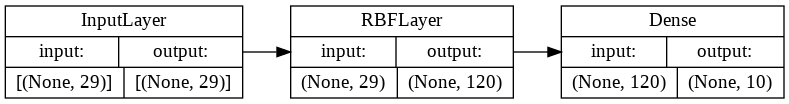

In [ ]:
from keras.utils import plot_model

plot_model(history.model, to_file='model.png', show_shapes=True, 
           show_layer_names=False, rankdir='LR')

In [ ]:
print(history.model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rbf_layer_8 (RBFLayer)       (None, 150)               4500      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1510      
Total params: 6,010
Trainable params: 6,010
Non-trainable params: 0
_________________________________________________________________
None


## Evaluation

### Plotting Accuracy and Loss

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


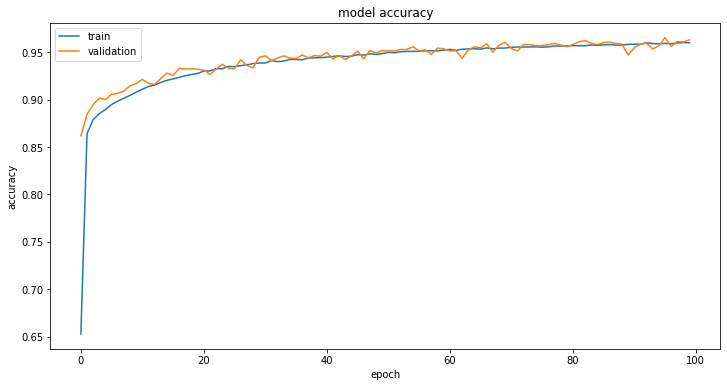

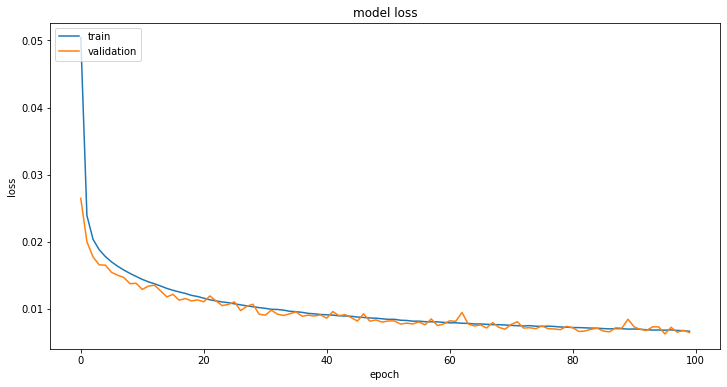

In [ ]:
plt.rcParams["figure.figsize"] = (12,6) # in order to increase the size of the plots
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Consfusion Matrix

In [ ]:
(_, _), (X, Y) = mnist.load_data() # getting the test data with original size

y_pred=model.predict(x_test_pca)
matrix = confusion_matrix(Y, y_pred)
display(matrix)

array([[ 949,    0,    2,    0,    0,    8,   10,    5,    6,    0],
       [   0, 1113,    4,    2,    0,    2,    3,    2,    9,    0],
       [   5,    0,  988,    3,    2,    3,    1,   15,   15,    0],
       [   0,    0,    8,  953,    0,   26,    0,   14,    6,    3],
       [   0,    0,    8,    0,  913,    0,   10,    6,    8,   37],
       [   3,    0,    0,    4,    1,  871,    6,    3,    3,    1],
       [   4,    2,    1,    0,    3,    7,  936,    1,    4,    0],
       [   0,    3,   12,    1,    1,    1,    0,  997,    4,    9],
       [   1,    0,    4,    4,    2,   10,    6,    7,  937,    3],
       [   1,    4,    1,    5,    6,   14,    1,   19,    9,  949]])

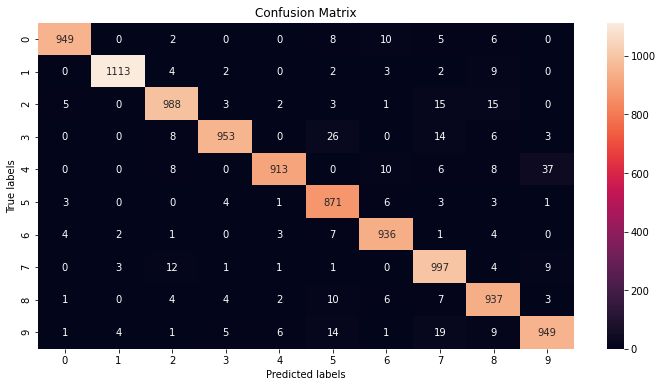

In [ ]:
plt.rcParams["figure.figsize"] = (12,6) # in order to increase the size of the plots
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['0', '1','2', '3', '4', '5', '6', '7', '8', '9']); 
ax.yaxis.set_ticklabels(['0', '1','2', '3', '4', '5', '6', '7', '8', '9']);

## Sources

* https://www.tutorialspoint.com/keras/keras_customized_layer.htm

* https://www.kaggle.com/residentmario/radial-basis-networks-and-custom-keras-layers

* https://www.quora.com/How-does-one-build-an-Radial-Basis-Function-RBF-network-in-TensorFlow

* http://mccormickml.com/2013/08/15/radial-basis-function-network-rbfn-tutorial/

* https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319

* https://keras.io/api/layers/initializers/#creating-custom-initializers

* https://www.sciencedirect.com/topics/computer-science/radial-basis-function

---
## Citation
* Vidnerová, Petra. RBF-Keras: an RBF Layer for Keras Library. 2019. Available at https://github.com/PetraVidnerova/rbf_for_tf2

  Thanks to the author of the very first citation: Lukas Brausch, et al. Towards a wearable low-cost ultrasound device for classification of muscle activity and muscle fatigue. 2019 doi:10.1145/3341163.3347749